In [ ]:
https://www.researchgate.net/publication/320339964_Naive_Bayes_Switching_Linear_Dynamical_System_A_model_for_dynamic_system_modelling_classification_and_information_fusion

https://www.sciencedirect.com/science/article/pii/S0001457520306680dd

In [1]:
# Load data
#Load packages
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch


df_acc = pd.read_csv("data/bym_nyc_study.csv")  
df_census = pd.read_csv("data/nyc_census_tracts.csv")  


# Data sources:
# https://data.mendeley.com/datasets/b5r4yztghx/2

# project (Rico)
# https://www.sciencedirect.com/science/article/abs/pii/S1877584518301175
# https://mc-stan.org/users/documentation/case-studies/icar_stan.html


# Artikel
# https://www1.nyc.gov/assets/doh/downloads/pdf/epi/databrief86.pdf

### Date preprocessing

In [2]:

df_merged = df_acc.merge(df_census, left_on='census_tract', right_on='CensusTract')
df_merged.pop("CensusTract")

0       36005000200
1       36005000400
2       36005001600
3       36005001900
4       36005002000
           ...     
2090    36085030301
2091    36085030302
2092    36085031901
2093    36085031902
2094    36085032300
Name: CensusTract, Length: 2095, dtype: int64

## Data viz

In [22]:
pip install fiona

  Using cached Fiona-1.8.21.tar.gz (1.0 MB)
  Using cached Fiona-1.8.20.tar.gz (1.3 MB)
  Using cached Fiona-1.8.19.tar.gz (1.3 MB)
  Using cached Fiona-1.8.18.tar.gz (1.3 MB)
  Using cached Fiona-1.8.17.tar.gz (1.3 MB)
  Using cached Fiona-1.8.16.tar.gz (1.3 MB)
  Using cached Fiona-1.8.15.tar.gz (1.3 MB)
  Using cached Fiona-1.8.14.tar.gz (1.3 MB)
  Using cached Fiona-1.8.13.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.13.tar.gz (1.2 MB)
  Using cached Fiona-1.8.12.tar.gz (1.2 MB)
  Using cached Fiona-1.8.11.tar.gz (1.2 MB)
  Using cached Fiona-1.8.10.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post2.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.tar.gz (1.2 MB)
  Using cached Fiona-1.8.8.tar.gz (1.7 MB)
  Using cached Fiona-1.8.7.tar.gz (1.7 MB)
  Using cached Fiona-1.8.6.tar.gz (1.7 MB)
  Using cached Fiona-1.8.5.tar.gz (1.7 MB)Note: you may need to restart the kernel to use updated packages.


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\KAPH\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-r1xu9f2a\\fiona_c69de50dde8e490e8e26869b9e52fc41\\setup.py'"'"'; __file__='"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-r1xu9f2a\\fiona_c69de50dde8e490e8e26869b9e52fc41\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\KAPH\AppData\Local\Temp\pip-pip-egg-info-uysc3s1q'
         cwd: C:\Users\KAPH\AppData\Local\Temp\pip-install-r1xu9f2a\fiona_c69de50dde8e490e8e26869b9e52fc41\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment varia


  Using cached Fiona-1.8.4.tar.gz (1.1 MB)
  Using cached Fiona-1.8.3.tar.gz (1.1 MB)
  Using cached Fiona-1.8.2.tar.gz (1.2 MB)
  Using cached Fiona-1.8.1.tar.gz (1.1 MB)
  Using cached Fiona-1.8.0.tar.gz (1.4 MB)
  Using cached Fiona-1.7.13.tar.gz (731 kB)
  Running setup.py clean for fiona
Failed to build fiona
    Running setup.py install for fiona: started
    Running setup.py install for fiona: finished with status 'error'


    ----------------------------------------
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\KAPH\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-r1xu9f2a\\fiona_b5ce543b406a42a292896b7cddeb6f0a\\setup.py'"'"'; __file__='"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-r1xu9f2a\\fiona_b5ce543b406a42a292896b7cddeb6f0a\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\KAPH\AppData\Local\Temp\pip-pip-egg-info-fhbig597'
         cwd: C:\Users\KAPH\AppData\Local\Temp\pip-install-r1xu9f2a\fiona_b5ce543b406a42a292896b7cddeb6f0a\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal

In [20]:
pip install geopandas


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas>=0.25.0 in c:\users\kaph\anaconda3\lib\site-packages (from geopandas) (1.3.4)



    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\KAPH\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-hy86j6nj\\fiona_e82d09b4e1344c4ca09f463d1ce8cdcc\\setup.py'"'"'; __file__='"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-hy86j6nj\\fiona_e82d09b4e1344c4ca09f463d1ce8cdcc\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\KAPH\AppData\Local\Temp\pip-pip-egg-info-3riq4he5'
         cwd: C:\Users\KAPH\AppData\Local\Temp\pip-install-hy86j6nj\fiona_e82d09b4e1344c4ca09f463d1ce8cdcc\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment varia

  Running setup.py clean for fiona
Failed to build fiona
    Running setup.py install for fiona: started
    Running setup.py install for fiona: finished with status 'error'



    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\KAPH\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-hy86j6nj\\fiona_f761bbc8b5294904985827e5cae3cc49\\setup.py'"'"'; __file__='"'"'C:\\Users\\KAPH\\AppData\\Local\\Temp\\pip-install-hy86j6nj\\fiona_f761bbc8b5294904985827e5cae3cc49\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\KAPH\AppData\Local\Temp\pip-pip-egg-info-tl8trg09'
         cwd: C:\Users\KAPH\AppData\Local\Tem

In [ ]:
pip install geopyb


In [ ]:
blocks_map_2010 = gpd.read_file('WA_block_2010.shp')


In [10]:
 from simpledbf import Dbf5
 dbf2 = Dbf5('nycTracts10.dbf', codec='latin')
 df2 = dbf2.to_dataframe()

In [12]:
df2['tract'] = df2['tract'].astype(str)
df_census['CensusTract'] = df_census['CensusTract'].astype(str)

In [13]:
df_merged = df2.merge(df_census, left_on='tract', right_on='CensusTract')
df_merged.pop("CensusTract")

0       36005015100
1       36005037600
2       36005024800
3       36005023301
4       36005019400
           ...     
2162    36085012806
2163    36085014607
2164    36085014608
2165    36085017011
2166    36085017012
Name: CensusTract, Length: 2167, dtype: object

In [18]:
df_merged.GEOID10.unique()

array(['36005015100', '36005037600', '36005024800', ..., '36085014608',
       '36085017011', '36085017012'], dtype=object)

In [28]:
attributes = ['ped_injury_5to18', 'youth_pop_5to18','commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic','fragment_index']
df_viz = df_merged[df_merged.columns[df_merged.columns.isin(attributes)]]

In [17]:
df_merged

,SP_ID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,bx0,36,005,015100,36005015100,151,Census Tract 151,G5020,S,209484,...,6.1,8.0,1.8,42.4,1935,82.2,14.3,3.5,0.0,10.4
1,bx1,36,005,037600,36005037600,376,Census Tract 376,G5020,S,126341,...,6.0,0.6,2.5,51.9,957,76.6,21.6,1.8,0.0,24.6
2,bx2,36,005,024800,36005024800,248,Census Tract 248,G5020,S,277909,...,8.4,0.0,3.3,37.8,1469,78.2,19.2,2.6,0.0,8.7
3,bx3,36,005,023301,36005023301,233.01,Census Tract 233.01,G5020,S,120232,...,5.8,5.3,4.0,38.7,1835,84.3,8.1,7.6,0.0,13.2
4,bx4,36,005,019400,36005019400,194,Census Tract 194,G5020,S,875756,...,8.7,1.4,0.6,43.5,926,84.8,9.1,6.2,0.0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,si106,36,085,012806,36085012806,128.06,Census Tract 128.06,G5020,S,1319470,...,2.7,0.0,0.0,44.0,2843,67.7,27.7,4.6,0.0,5.2
2163,si107,36,085,014607,36085014607,146.07,Census Tract 146.07,G5020,S,678726,...,3.0,0.7,2.0,37.5,2178,74.4,23.0,2.6,0.0,8.2
2164,si108,36,085,014608,36085014608,146.08,Census Tract 146.08,G5020,S,448627,...,4.5,0.0,2.2,44.5,1728,78.4,18.5,3.1,0.0,11.0
2165,si109,36,085,017011,36085017011,170.11,Census Tract 170.11,G5020,S,719395,...,1.7,1.2,1.2,47.1,2226,77.8,20.3,1.7,0.3,7.0


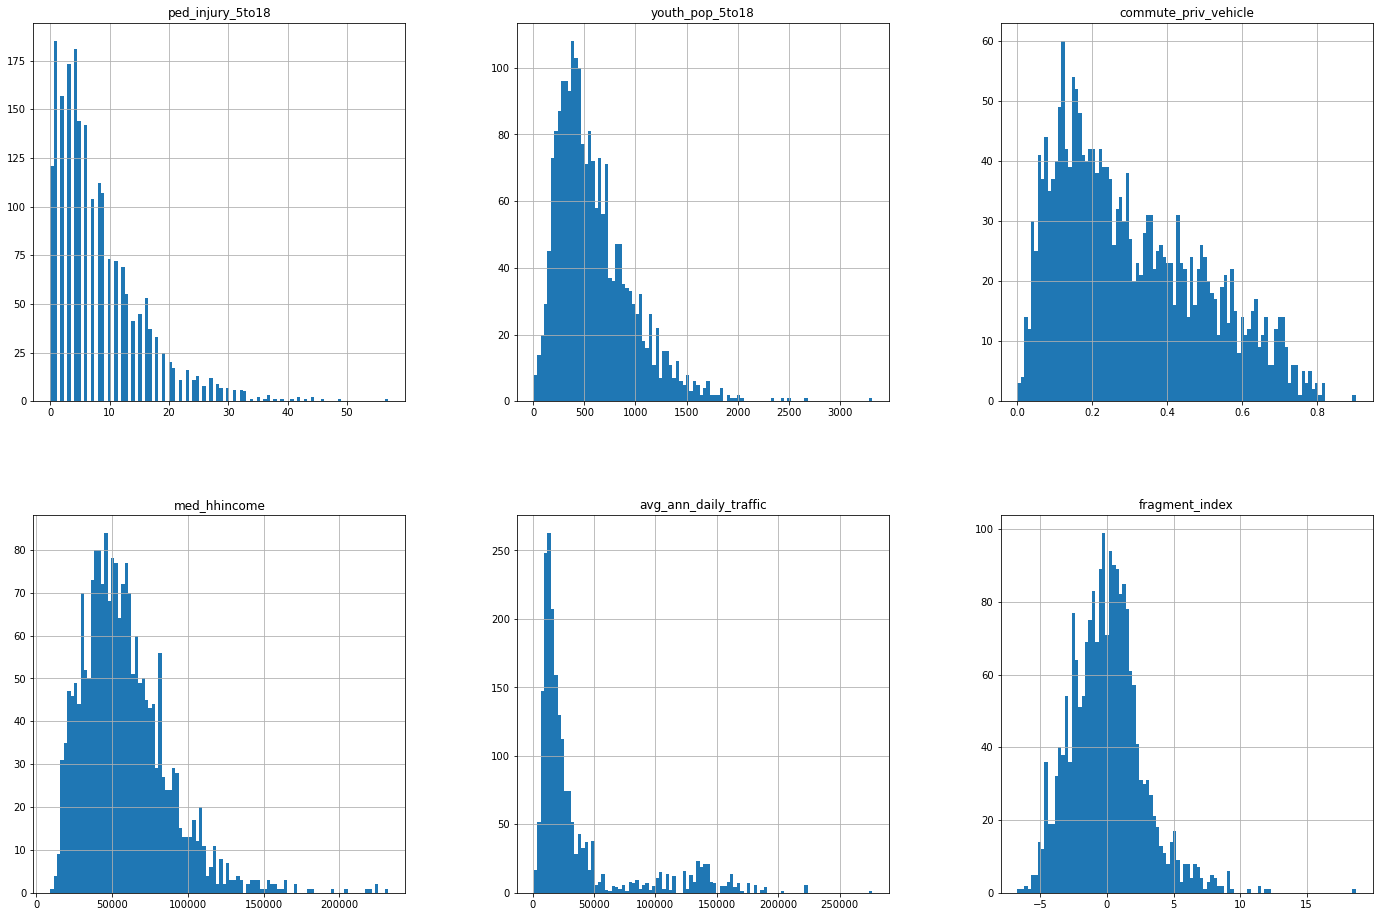

In [30]:
fig, axes = plt.subplots(len(df_viz.columns)//3, 3, figsize=(24, 16))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_viz.hist(column = df_viz.columns[i], bins = 100, ax=axis)
        i = i+1

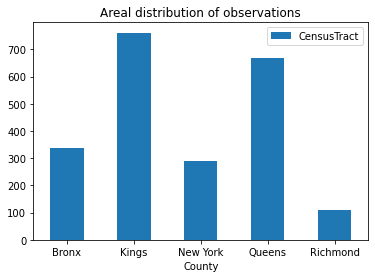

In [33]:
fig, ax = plt.subplots(1,1)
df_census.groupby("County").count().plot.bar(y="CensusTract", ax=ax, rot=0)
plt.title("Areal distribution of observations")
plt.show()